# STA 220 Assignment 4

Due __March 8, 2024__ by __11:59pm__. Submit your work by uploading it to Gradescope through Canvas.

Instructions:

1. Provide your solutions in new cells following each exercise description. Create as many new cells as necessary. Use code cells for your Python scripts and Markdown cells for explanatory text or answers to non-coding questions. Answer all textual questions in complete sentences.
2. The use of assistive tools is permitted, but must be indicated. You will be graded on you proficiency in coding. Produce high quality code by adhering to proper programming principles. 
3. Export the .jpynb as .pdf and submit it on Gradescope in time. To facilitate grading, indicate the area of the solution on the submission. Submissions without indication will be marked down. No late submissions accepted. 
4. If test cases are given, your solution must be in the same format. 
5. The total number of points is 10. 

In [132]:
import re
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from bs4 import BeautifulSoup, NavigableString
import pandas as pd
import json
import requests
import warnings
import plotly.graph_objects as go
import geopandas as gpd
import matplotlib.pyplot as plt
from bokeh.io import show, output_file
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Slider, CustomJS
from bokeh.layouts import column
warnings.filterwarnings('ignore')

__Exercise 1__ Lets retrieve data from the [CIA World Factbook](https://www.cia.gov/the-world-factbook/) and visualize parts of it. 

__(a)__ Using devtools, find a way to retrieve the names of all listed world entities. In order to navigate to their respective site, I assembled the path by processing the country names. To this end, __(i)__ write a function `process_names` that processes the name as string according to the requests query parameter. _Run:_ 
```
process_names('Falkland Islands (Islas Malvinas)')
```

In [2]:
def process_names(name):
    
    words = re.findall(r'\b\w+\b', name.lower())
    processed_name = '-'.join(words)

    return processed_name

In [3]:
print(process_names('Falkland Islands (Islas Malvinas)'))
print(process_names('French Southern and Antarctic Lands'))
print(process_names('Bahamas, The'))

falkland-islands-islas-malvinas
french-southern-and-antarctic-lands
bahamas-the


__(ii)__ Obtain all world entity names. _How many have you found? Hint: I could not retrieve data for all 266 entities that the CIA WFB claims to have._

In [54]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.set_page_load_timeout(20)
countries = {}

try:
    driver.get("https://www.cia.gov/the-world-factbook/countries/")

    for letter in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ':
        try:
            button = driver.find_element('xpath', f"//button[.//span[text()='{letter}']]")
            button.click()
            time.sleep(2)
            
            while True:
                soup = BeautifulSoup(driver.page_source, 'html.parser')
                country_tags = soup.select('a[href*="/the-world-factbook/countries/"]')
                for tag in country_tags:
                    if tag.text.strip() != '' and tag.text.strip() != 'Countries' and tag.text.strip() != 'World':
                        countries[tag.text.strip()] = tag['href'].strip().split('/')[-2]
                try:
                    next_page_button = driver.find_element('css selector', 'span.pagination__arrow-right:not(.disabled)')
                    next_page_button.click()
                    time.sleep(2)
                except NoSuchElementException:
                    break

        except TimeoutException:
            print(f"Loading the page took too long for letter {letter}.")

finally:
    driver.quit()

In [55]:
print(f"Total countries found: {len(set(countries.values()))}")

Total countries found: 254


__(iii)__ Write a function `get_info` takes a country name as string as input and return all the information as json that is displayed on its respective site. Use the retrieved data set for the next exercises. _Hint: If you rate-limit your requests (you should!) this may take up to 10 minutes._

In [7]:
import requests

def get_info(country_name):

    url_country_name = countries[country_name]
    info_country_name = process_names(country_name)
    url = f"https://www.cia.gov/the-world-factbook/page-data/countries/{url_country_name}/page-data.json"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        info[info_country_name] = data
    else:
        print(f"Failed to retrieve data for {country}")
    time.sleep(3)

info = {}
for country in countries.keys():
    get_info(country)


__(b)__ Lets learn about the newest updated data points in the CIA world factbook - the merchant marine! __(i)__ Write a function `ports` that returns a list of all major seaports of a given country. _Run:_

```
ports('United States')
```

In [8]:
def ports(country_name):

    data = info[process_names(country_name)]
    
    for entry in data['result']['data']['fields']['nodes']:
        if entry['name'].strip() == 'Ports and terminals':
            soup = BeautifulSoup(entry['data'], 'html.parser')
            strong_tags = soup.find_all('strong')
            for tag in strong_tags:
                if 'major seaport(s):' in tag.text:
                    next_strong_tag = tag.find_next('strong')
                    seaport_data = ""
                    
                    if next_strong_tag:
                        for t in tag.next_siblings:
                            if(t == next_strong_tag):
                                break
                            if not (isinstance(t, NavigableString) or t.name != 'em'):
                                continue  
                            seaport_data += t.text if not isinstance(t, NavigableString) else t
                    else:
                        for t in tag.next_siblings:
                            if not (isinstance(t, NavigableString) or t.name != 'em'):
                                continue  
                            seaport_data += t.text if not isinstance(t, NavigableString) else t
                    return seaport_data.strip()
            return "NA"
    return "NA"
            

In [9]:
ports_list = ports('united-states').split(',')
ports_list


['Charleston',
 ' Hampton Roads',
 ' New York/New Jersey',
 ' Savannah Long Beach',
 ' Los Angeles',
 ' Oakland',
 ' Seattle/Tacoma Houston']

__(ii)__ Lets put a marker on a world map corresponding to the location of all major seaports that you retrieved. Use the [Nominatim](https://nominatim.org/) API to get latitute-longitude pairs. Make structured queries and pass the `city` and `country` keys. Use the first value that is returned. 

_Print the world map. Name three markers that are apparently misplaced._

In [10]:
country_seaports = {}
for country in countries:
    country_seaports[country] = ports(country).split(',')

In [11]:
def get_lat_long(seaport, country):
    params = {'city': seaport, 'country': country, 'format': 'json'}
    response = requests.get("https://nominatim.openstreetmap.org/search", params=params)
    data = response.json()
    if data:
        return float(data[0]['lat']), float(data[0]['lon'])
    else:
        return None, None

In [12]:
seaport_names, longitudes, latitudes = [], [], []
for country, seaports in country_seaports.items():
    for seaport in seaports:
        lat, lon = get_lat_long(seaport, country)
        time.sleep(3)
        if(lat and lon and seaport != 'NA'):
            seaport_names.append(seaport)
            latitudes.append(lat)
            longitudes.append(lon)

In [13]:
fig = go.Figure(data=go.Scattergeo(
    lon = longitudes,
    lat = latitudes,
    text = seaport_names, 
    mode = 'markers',
    marker = dict(
        size = 5,
        color = 'red',
        line = dict(
            width = 0.5,
            color = 'rgba(68, 68, 68, 0)'
        )
    )
))

fig.update_layout(
    title = 'World Seaports',
    geo = dict(
        scope = 'world',
        projection_type = 'natural earth',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig.show()

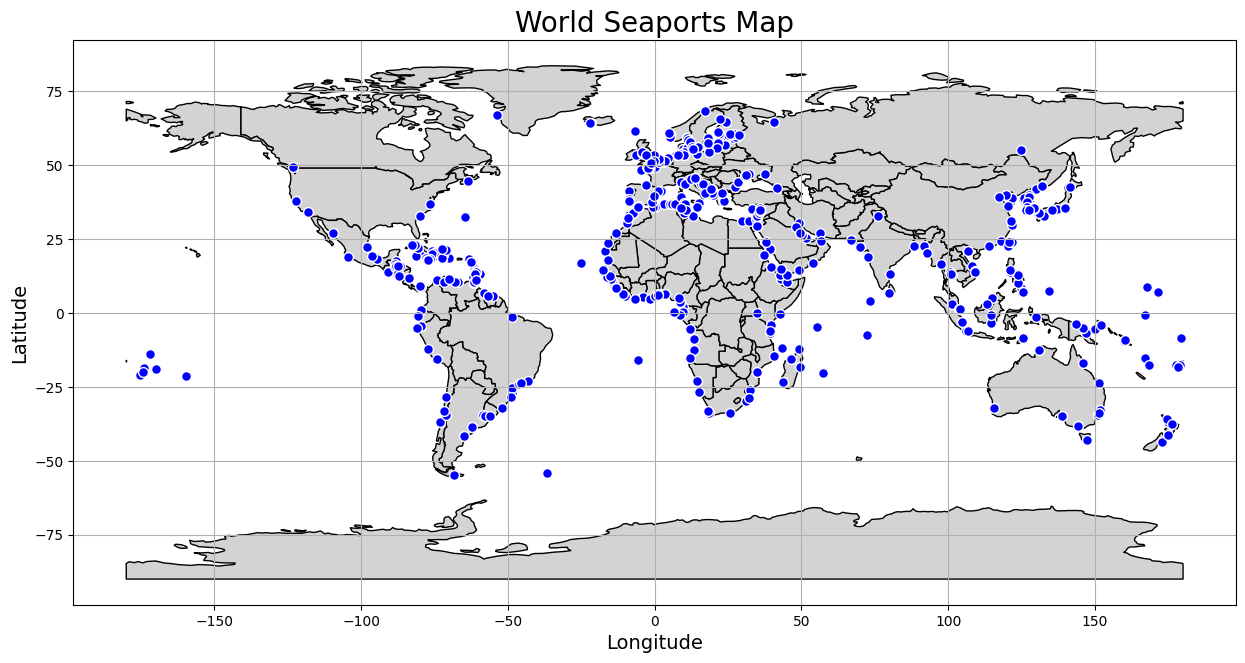

In [137]:
df = pd.DataFrame({
    'Seaport': seaport_names,
    'Latitude': latitudes,
    'Longitude': longitudes
})

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf.crs = 'EPSG:4326'
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(1, 1, figsize=(15, 10)) 

world.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, marker='o', color='blue', edgecolor='white', markersize=50)

# Customize the plot
ax.set_title('World Seaports Map', fontsize=20)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.set_axis_on() 
ax.grid(True) 

plt.show()


In [14]:
print("Misplaced Markers: Kandla, Belawan, Vostochnyy")

Misplaced Markers: Kandla, Belawan, Vostochnyy


__(iii)__ Amongst all countries with a major seaport, return the four that have the largest fleet of _bulk carriers_. Amongst all countries with no coastline, return the four that have the largest merchant marine fleet overall. 

In [67]:
def get_countries_with_largest_fleet_of_bulk_careers():

    bulk_carriers = []

    for country, _ in countries.items():
        data = info[process_names(country)]
        for entry in data['result']['data']['fields']['nodes']:
            if entry['name'].strip() == 'Merchant marine':
                soup = BeautifulSoup(entry['data'], 'html.parser')
                strong_tags = soup.find_all('strong')
                for tag in strong_tags:
                    if 'by type:' in tag.text:
                        next_strong_tag = tag.find_next('strong')
                        seaport_data = ""
                        
                        if next_strong_tag:
                            for t in tag.next_siblings:
                                if(t == next_strong_tag):
                                    break
                                seaport_data += t.text
                        else:
                            for t in tag.next_siblings:
                                seaport_data += t.text 

                        pattern = re.compile(r'\b(\w+)\s+\w* (\d+(?:,\d{3})*)')
                        matches = pattern.findall(seaport_data)

                        if(len(matches) !=  0 and matches[0][0] == 'bulk'):
                            count = matches[0][1].replace(',', '')
                            count = int(count)
                            bulk_carriers.append((count, country))
                            break

                        break
                break
                
    return bulk_carriers

In [68]:
bulk_careers = get_countries_with_largest_fleet_of_bulk_careers()

In [74]:
ans = sorted(bulk_careers, key=lambda x: -x[0])
print('Countries with largest fleet of bulk carriers : ', ans[:4])

Countries with largest fleet of bulk carriers :  [(2732, 'Panama'), (1939, 'Marshall Islands'), (1895, 'Liberia'), (1831, 'China')]


In [70]:
def get_marine_fleet_of_countries_with_no_coastline():

    marine_fleet = []

    for country, _ in countries.items():
        data = info[process_names(country)]
        for entry in data['result']['data']['fields']['nodes']:
            if(entry['name'].strip() == 'Coastline'):
                if(entry['data'].strip().split(' ')[0][0] == '<' or
                   entry['data'].strip().split(' ')[0][0] == 'N'):
                    continue
                len_of_coastline = int(entry['data'].strip().split(' ')[0][0])
                if(len_of_coastline == 0):
                    for entry in data['result']['data']['fields']['nodes']:
                        if entry['name'].strip() == 'Merchant marine':
                            soup = BeautifulSoup(entry['data'], 'html.parser')
                            strong_tags = soup.find_all('strong')
                            for tag in strong_tags:
                                if 'total:' in tag.text:
                                    next_strong_tag = tag.find_next('strong')
                                    total_data = ""
                                    
                                    if next_strong_tag:
                                        for t in tag.next_siblings:
                                            if(t == next_strong_tag):
                                                break
                                            total_data += t.text
                                    else:
                                        for t in tag.next_siblings:
                                            total_data += t.text 
                                    total_count = int(total_data.strip().split(' ')[0])
                                    marine_fleet.append((total_count, country))

                                    break
                            break
                break
                
    return marine_fleet

In [71]:
marine_fleets = get_marine_fleet_of_countries_with_no_coastline()

In [73]:
ans = sorted(marine_fleets, key=lambda x: -x[0])
print("Countries with no coastline and have the largest merchant marine fleet : ", ans[:4])

Countries with no coastline and have the largest merchant marine fleet :  [(318, 'Mongolia'), (312, 'Azerbaijan'), (147, 'Luxembourg'), (122, 'Kazakhstan')]


__(c)__ Now, lets classify whether a country is or has been controlled by the United Kingdom by analyzing the provided background information text. __(i)__ Implement a (very simple!) classification method that performs this task. My function `was_british` correctly identifies the countries of Pakistan and Russia, but incorrectly classifies Spain and the United States. 

_How many world entities do you find to be current or former parts of the British Empire?_

In [166]:
def was_british(country):
    data = info.get(process_names(country), '')
    if(data == ''):
        return False
    
    background_info = ""

    for entry in data['result']['data']['fields']['nodes']:
        if(entry['name'].strip() == 'Background'):
            background_info = entry['data'].strip()
            break

    keywords = ["British Empire", "British India", "under British", "Britain's", 'British Commonwealth', 'British Mandate', 'British colony', 'British']
    

    if(background_info != ""):
        for keyword in keywords:
            if keyword in background_info:
                return True 
            
        return False 
    return False


In [167]:
print(was_british('Pakistan'))
print(was_british('Russia'))

True
False


In [168]:
print(was_british('Spain'))
print(was_british('United States'))

False
True


In [169]:
def get_iso_codes_of_british_colonies():

    url = "https://www.cia.gov/the-world-factbook/references/country-data-codes/"
    response = requests.get(url)
    webpage_content = response.content

    soup = BeautifulSoup(webpage_content, 'html.parser')

    table = soup.find('table', {'class': 'content-table table-auto'})

    iso_codes = {}

    for row in table.find_all('tr')[1:]:  
        cols = row.find_all('td')
        country_name = cols[0].text.strip()
        if(was_british(country_name)):
            iso_code_full = cols[2].text.strip()
            if '|' in iso_code_full:
                iso_code = iso_code_full.split('|')[1]
                iso_codes[country_name] = iso_code

    return iso_codes

In [170]:
iso_codes_of_british_colonies = get_iso_codes_of_british_colonies()
print(f"{len(iso_codes_of_british_colonies)} world entities are current or former parts of the British Empire")

92 world entities are current or former parts of the British Empire


__(ii)__ Retrieve the ISO codes from [here](https://www.cia.gov/the-world-factbook/references/country-data-codes/) and use them to color all countries on a world map that you have determined to be former parts of the British Empire. The map should look something like [this](https://en.wikipedia.org/wiki/British_Empire#/media/File:The_British_Empire_5.png). 

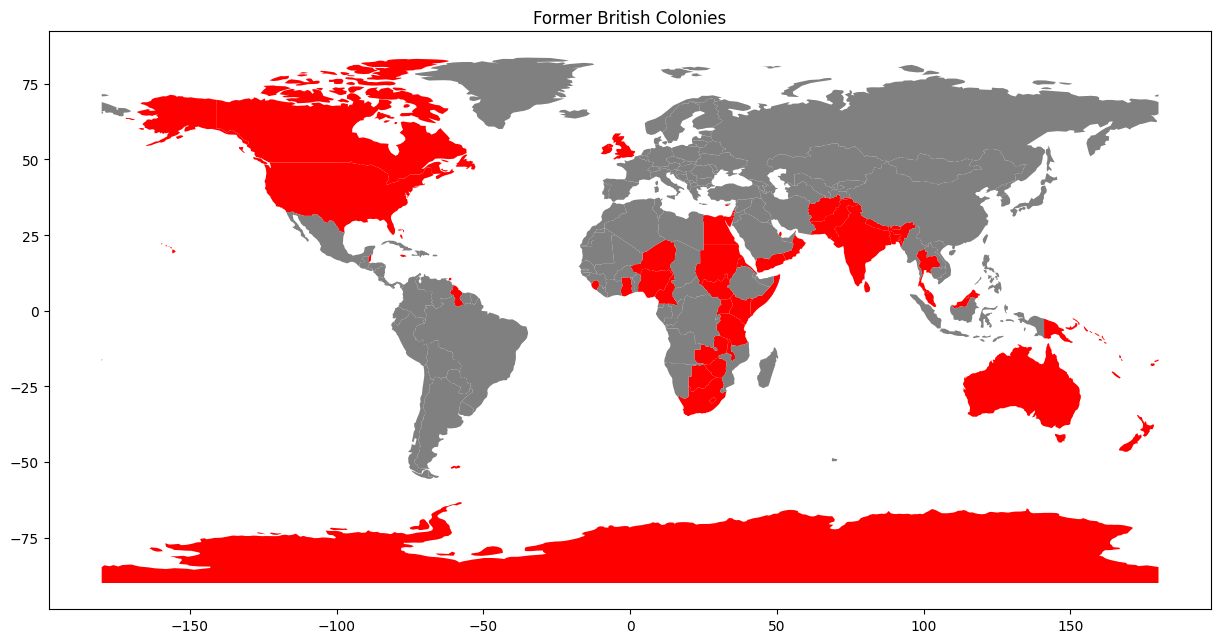

In [171]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

british_colonies_iso = list(iso_codes_of_british_colonies.values())

world['was_british_colony'] = world['iso_a3'].apply(lambda x: x in british_colonies_iso)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world[world['was_british_colony']].plot(ax=ax, color='red')  # British colonies in red
world[~world['was_british_colony']].plot(ax=ax, color='grey')  # Other countries in grey
ax.set_title('Former British Colonies')
plt.show()

__(d)__ Lets build our own population pyramide (with only three steps) according to the obtained data (`0-14`, `15-64`, `65+`). Given the current health expenditure as threshold, we want to obtain create a population pyramide for all aggregated population values. __(i)__ Assemble a data frame that given a threshold shows the aggregated population values of all data points which current health expenditure does not exceed the threshold, separated by gender. The first four rows of data frame `df` are given below. 

_How many distinct thresholds do you find?_

In [925]:
df.head(4)

,Groups,Male,Female,Threshold
0,0-14 years,999784527,940797401,1.7
1,15-64 years,2595737039,2532780848,1.7
2,65 years and over,356032162,441482834,1.7
3,0-14 years,927167037,870891052,2.9


In [ ]:
def extract_healthcare_exp(expenditure_str):
    match = re.search(r"(\d+\.?\d*)%", expenditure_str)
    if match:
        return float(match.group(1))
    return None

In [ ]:
def extract_population_data(age_structure_str):
    age_groups = re.findall(r"<strong>(.*?)</strong>.*?male\s+([,\d]+)/female\s+([,\d]+)", age_structure_str, re.DOTALL)
    return age_groups

In [ ]:
thresholds = set()
for country, _ in countries.items():
    data = info[process_names(country)]
    for entry in data['result']['data']['fields']['nodes']:
        if entry['name'].strip() == 'Current health expenditure':
            health_expenditure = entry['data'].strip()
            threshold = extract_healthcare_exp(health_expenditure)
            if threshold is not None:
                thresholds.add(threshold)
                break

In [93]:
print("Number of distinct thresholds : ", len(thresholds))

Number of distinct thresholds :  92


In [88]:
sorted_thresholds = sorted(list(thresholds))

aggregated_data = [] 
for threshold in sorted_thresholds:
    threshold_data = {}
    for country, _ in countries.items():
        data = info[process_names(country)]
        health_expenditure = None
        for entry in data['result']['data']['fields']['nodes']:
            if entry['name'].strip() == 'Current health expenditure':
                health_expenditure = extract_healthcare_exp(entry['data'].strip())
                break
        
        if health_expenditure and health_expenditure >= threshold:
            for entry in data['result']['data']['fields']['nodes']:
                if entry['name'].strip() == 'Age structure':
                    age_structure = entry['data'].strip()
                    population_data = extract_population_data(age_structure)
                    for age_group, male, female in population_data:
                        key = (age_group, threshold)
                        male = int(male.replace(',', ''))
                        female = int(female.replace(',', ''))
                        if key not in threshold_data:
                            threshold_data[key] = {'Male': male, 'Female': female}
                        else:
                            threshold_data[key]['Male'] += male
                            threshold_data[key]['Female'] += female
    
    for key, counts in threshold_data.items():
        aggregated_data.append((*key, counts['Male'], counts['Female']))

df_aggregated = pd.DataFrame(aggregated_data, columns=['Age Group', 'Threshold', 'Male', 'Female'])
df_aggregated.sort_values(by=['Threshold', 'Age Group'], inplace=True)
df_aggregated.reset_index(drop=True, inplace=True)
df_aggregated.head()

,Age Group,Threshold,Male,Female
0,0-14 years:,1.7,999784527,940797401
1,15-64 years:,1.7,2595737039,2532780848
2,65 years and over:,1.7,356032162,441482834
3,0-14 years:,2.0,999783005,940795953
4,15-64 years:,2.0,2595728401,2532772290


__(ii)__ Using `bokeh.io`, create a client-based interactive opulation pyramid that displays the data from (i) according to a set threshold (or the closest threshold that exists). Make sure that the pyramid is well crafted, similar to [this](https://en.wikipedia.org/wiki/Population_pyramid#/media/File:Angola_population_pyramid_2005.svg), but with a slider and only three population groups. 

_Either provide a link to a site that hosts the interactive graphic, or provide a non-interactive for threshold value `10`._

In [173]:
df_filtered['Male'] = -df_filtered['Male']
df_filtered.head()

,Age Group,Threshold,Male,Female
210,0-14 years:,10.0,110643536,105619198
211,15-64 years:,10.0,386123983,384207083
212,65 years and over:,10.0,96154385,120542005


In [128]:
initial_threshold = 10

df_filtered = df_aggregated[df_aggregated['Threshold'] == initial_threshold].drop_duplicates(subset=['Age Group'])
df_filtered['Male'] = -df_filtered['Male'].abs()
output_file("population_pyramid.html")

source = ColumnDataSource(df_filtered)
p = figure(y_range=df_filtered['Age Group'].tolist(), height=250, title="Population Pyramid",
           toolbar_location=None, x_range=(-3000000000, 3000000000))

p.hbar(y='Age Group', right='Male', height=0.4, source=source, color="blue")
p.hbar(y='Age Group', right='Female', height=0.4, source=source, color="pink")

slider = Slider(start=df_aggregated['Threshold'].min(), end=df_aggregated['Threshold'].max(), value=initial_threshold, step=0.1, title="Threshold")
all_data = ColumnDataSource(df_aggregated.to_dict('list'))

callback = CustomJS(args=dict(source=source, all_data=all_data), code="""
    const data = source.data;
    const threshold = cb_obj.value;
                    console.log(threshold);
    const new_data = {'Age Group': [], 'Male': [], 'Female': [], 'Threshold': []};

    let closest = 1000000000
    let closest_threshold = 10         
    for (let i = 0; i < all_data.data['Threshold'].length; i++) {
        let diff = Math.abs(threshold-all_data.data['Threshold'][i]);
        if(diff < closest){
            closest = diff; 
            closest_threshold = all_data.data['Threshold'][i]
        }
    }

    for (let i = 0; i < all_data.data['Threshold'].length; i++) {
        if (all_data.data['Threshold'][i] == closest_threshold) {
            new_data['Age Group'].push(all_data.data['Age Group'][i]);
            new_data['Male'].push(-Math.abs(all_data.data['Male'][i])); // Ensure 'Male' values are negative
            new_data['Female'].push(Math.abs(all_data.data['Female'][i])); // Ensure 'Female' values are positive
            new_data['Threshold'].push(all_data.data['Threshold'][i]);
        }
    }

    data['Age Group'] = new_data['Age Group'];
    data['Male'] = new_data['Male'];
    data['Female'] = new_data['Female'];
    data['Threshold'] = new_data['Threshold'];

    source.change.emit();
""")


slider.js_on_change('value', callback)
layout = column(slider, p)
show(layout)

Below is the population chart for threshold value = 10


![Alt text](Population_chart_threshold_10.png "Optional title")

I have hosted my answer on github pages with interactive slider, you can access it from this link : [Link](https://kaushalnaresh.github.io/Data_And_Web_Technologies_For_Data_Science/HW4/population_pyramid.html)